# Setting up Thermochemistry Calculations with Cantera and Spitfire

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- Importing thermochemistry data with Cantera
- A hydrogen-air ignition calculation

## Introduction

Building reactor models of chemical processes starts with acquiring thermochemistry data of the different chemical species involved and the set of reactions they undergo. To manage mechanism data, Spitfire uses the Python interface of [Cantera](https://cantera.org/). It is highly recommended that advanced users become familiar with Cantera's Python interface, not only for using Spitfire but also for the wealth of useful capabilities provided directly by Cantera.

Mechanism data can be passed to Spitfire in any way that it can be provided to Cantera.
This can be done with either a database or manually in Python.

1. Provide a Cantera YAML/CTI/XML file (YAML format is now Cantera's preference)
2. Build a mechanism programmatically with Cantera's Python interface

## Griffon

One of the key research topics involved in Spitfire's earliest developments was the design of numerical methods for complex chemistry problems. For this reason all reaction rates and sensitivities (for Jacobian matrices) are evaluated in the Griffon code, an internal C++ library of Spitfire. Griffon is the "engine" for thermochemistry with Spitfire that is wrapped by Cython code and precompiled into the `spitfire.griffon` package. Griffon computes reaction rates and right-hand sides and analytical Jacobian matrices for reactors and flamelets in addition to some optimized solvers (e.g., a linear solver for flamelet models).


## `HomogeneousReactor`

While Griffon's functionality is largely made available to users, Spitfire provides Python classes to simplify the solution of canonical reactors (`HomogeneneousReactor` in `spitfire.chemistry.reactors`). Python classes are also provided for non-premixed flamelets (`Flamelet` in `spitfire.chemistry.flamelet`), and three-stream flamelets have undergone a small amount of development. Flamelet models will be discussed in detail in other tutorials.

A number of reactor models are available, namely all possibly combinations of the following characteristics:

- **configuration**: constant-pressure (isobaric) or constant-volume (isochoric)
- **heat transfer**: adiabatic, isothermal, or diathermal (radiative and convective heat transfer) walls
- **mass transfer**: closed or open reactors with an imposed feed stream and residence time

Parameters such as the residence time, feed stream, or heat transfer parameters (e.g., external convection temperature) may be specied as arbitrary functions of time.

## `ChemicalMechanismSpec`

In order to use Griffon functions or the reactor and flamelet classes, Spitfire provides the `ChemicalMechanismSpec` class to interface with Cantera data. In the cell below we import this class and build an instance with the `h2-burke.yaml` Cantera file, which contains data for hydrogen combustion. The "group_name" argument tells Cantera which phase to use in its input file (some contain several options with different groups of species or different transport properties).

In [1]:
from spitfire import ChemicalMechanismSpec

mech = ChemicalMechanismSpec(cantera_input='h2-burke.yaml', group_name='h2-burke')

## Streams and Mixing

The next step is to make a mixture of hydrogen and air and "spark" it to a high temperature to ignite.
To make streams of reactants the mechanism provides the `stream` method. This produces an instance of a Cantera `Quantity`, which you can create without the `ChemicalMechanismSpec` if you know Cantera well.

Below we make a stream of pure hydrogen at 300 K and one atmosphere, and a stream of air at standard temperature and pressure. Note that the `'TPX'` string is a Cantera detail: see [Cantera's documentation](https://www.cantera.org/docs/sphinx/html/cython/importing.html#cantera.Quantity) for more details regarding stream initialiation and all the various options.

In [2]:
h2 = mech.stream('TPX', (300, 101325, 'H2:1'))
air = mech.stream(stp_air=True)

Now we take these streams and mix them so that the resultant stream is a stoichiometric mixture which has an [equivalence ratio](https://en.wikipedia.org/wiki/Air%E2%80%93fuel_ratio#Fuel%E2%80%93air_equivalence_ratio_(%CF%95)) of one. We then set the temperature and pressure.

In [3]:
mix = mech.mix_for_equivalence_ratio(1.0, h2, air)
mix.TP = 950., 101325.

## Building The Reactor

To build a `HomogeneousReactor` we now simply provide the `ChemicalMechanismSpec` object (which contains things like a Cantera `Solution` object and a Griffon objec) and the `mix` stream we made above which is the initial state of the reactor. We also provide the configuration, heat transfer, and mass transfer settings. For adiabatic and closed reactors these settings are pretty limited but for more complicated reactors there will be more arguments needed.

## Integrating in Time

We can integrate the reactor in time towards a steady state with the `integrate_to_steady` method below, which can take all kinds of arguments to control details of the time-stepping. Without any arguments it simply uses the defaults to integrate a reactor until a steady state is obtained.

In [4]:
from spitfire import HomogeneousReactor

r = HomogeneousReactor(mech, mix,
                       configuration='isochoric',
                       heat_transfer='adiabatic',
                       mass_transfer='closed')

output = r.integrate_to_steady()

## Plotting variables over time

The `output` variable above that was returned by the reactor integration is a Spitfire `Library` object that will be discussed in greater detail in later notebooks (it is critical when solving flamelets to build tabulated chemistry models). To plot the temperature of the reactor over time, for instance, you can simply use the following code.

The output from the reactor `integrate*` call contains temperature, all of the species mass fractions, and for an isochoric reactor the density (for isobaric the pressure will be included so the thermodynamic state can be reconstructed from the output alone). This means we can plot several mass fractions as follows.

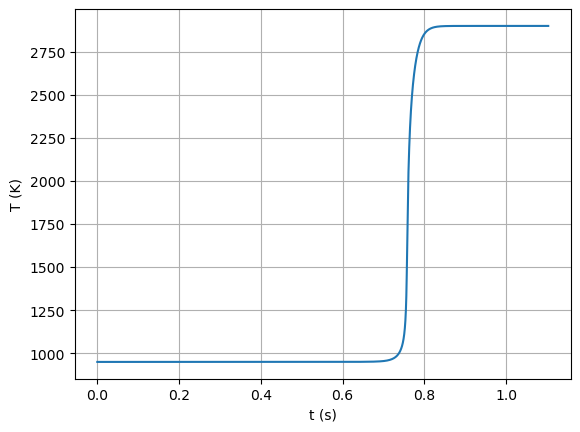

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(output.time_values * 1e3, output['temperature'])
plt.xlabel('t (s)')
plt.ylabel('T (K)')
plt.grid()
plt.show()

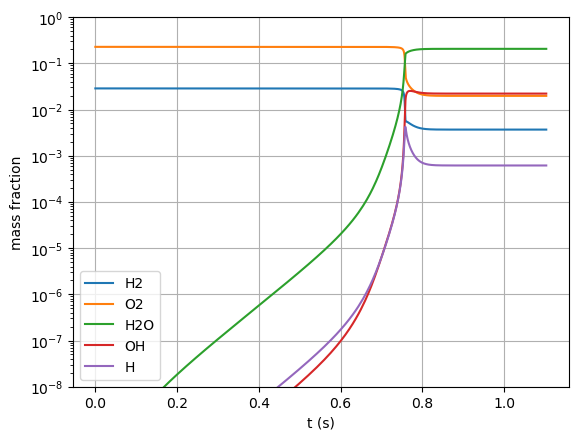

In [7]:
for s in ['H2', 'O2', 'H2O', 'OH', 'H']:
    plt.semilogy(output.time_values * 1e3, output['mass fraction ' + s], label=s)
plt.xlabel('t (s)')
plt.ylabel('mass fraction')
plt.ylim([1e-8, 1])
plt.grid()
plt.legend(loc='best')
plt.show()

## Post-processing quantities

To compute quantities like reaction rates, species production rates, enthalpy, pressure, etc. on the solution trajectory returned by `integrate_to_steady` we can use the `spitfire.chemistry.analysis` package. To facilitate the use of Cantera's Python interface, use the `get_ct_solution_array` method to return a Cantera `SolutionArray` that can compute quantities across a range of states just like a Cantera `Quantity` or `Solution` object. Note the `shape` output from the function can be used to reshape and add newly computed properties to the output library (this is much more important later on for tabulated chemistry models).

In [8]:
from spitfire import get_ct_solution_array

ctsol, shape = get_ct_solution_array(mech, output)

Now we'll plot the rate of the important chain-branching reaction, `H + O2 <-> O + OH`, which happens to be the 0-th reaction in this mechanism, alongside the temperature on a twin axis.

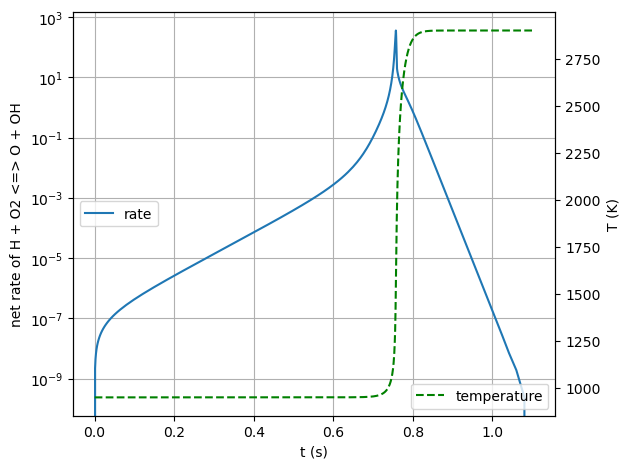

In [10]:
qcb = ctsol.net_rates_of_progress[:, 0]

fig, ax1 = plt.subplots()
ax1.semilogy(output.time_values * 1e3, qcb, label='rate')
ax1.set_xlabel('t (s)')
ax1.set_ylabel(f'net rate of {mech.gas.reaction(0).equation}')
ax1.legend(loc='center left')

ax2 = ax1.twinx()
ax2.plot(output.time_values * 1e3, output['temperature'], 'g--', label='temperature')
ax2.set_ylabel('T (K)')
ax2.legend(loc='lower right')

ax1.grid()
fig.tight_layout()
plt.show()

## Conclusions

This notebook has introduced the use of Spitfire to solve a simple reactor model and the use of Cantera to load mechanism data and post-process thermochemical quantities on computed solutions. More detailed options for reactor simulations will be presented in the next notebooks.